# Jupyter Notebook styling
## (It's just easier on the eyes)

In [1]:
%%html
<style>
    .container { width:100% !important; }
    .output_wrapper, .output {
        height:auto !important;
    }
    .output_scroll {
        box-shadow:none !important;
        webkit-box-shadow:none !important;
        overflow-y: hidden !important;
        overflow-x: hidden !important;
    }
</style>

# Imports and set-up

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
#Get data and clean up, translate:
df = pd.read_csv('./data/Provincial data/QuebecConfirmedCases.csv', parse_dates=['Date de résultat du test'])
cases = df.copy()
cases.rename(columns={'Date de résultat du test':'Test Date','Cas confirmés':'Cumulative Confirmed Cases','Annotations 1':'Notes'}, inplace = True)
cases['New Cases'] = cases['Cumulative Confirmed Cases'].diff().fillna(0).astype(int)
cases.insert(1,'New Cases',cases.pop('New Cases'))
cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1332 entries, 0 to 1331
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Test Date                   1332 non-null   datetime64[ns]
 1   New Cases                   1332 non-null   int64         
 2   Cumulative Confirmed Cases  1332 non-null   int64         
 3   Notes                       1 non-null      object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 41.8+ KB


# Plotting critical sections of interest

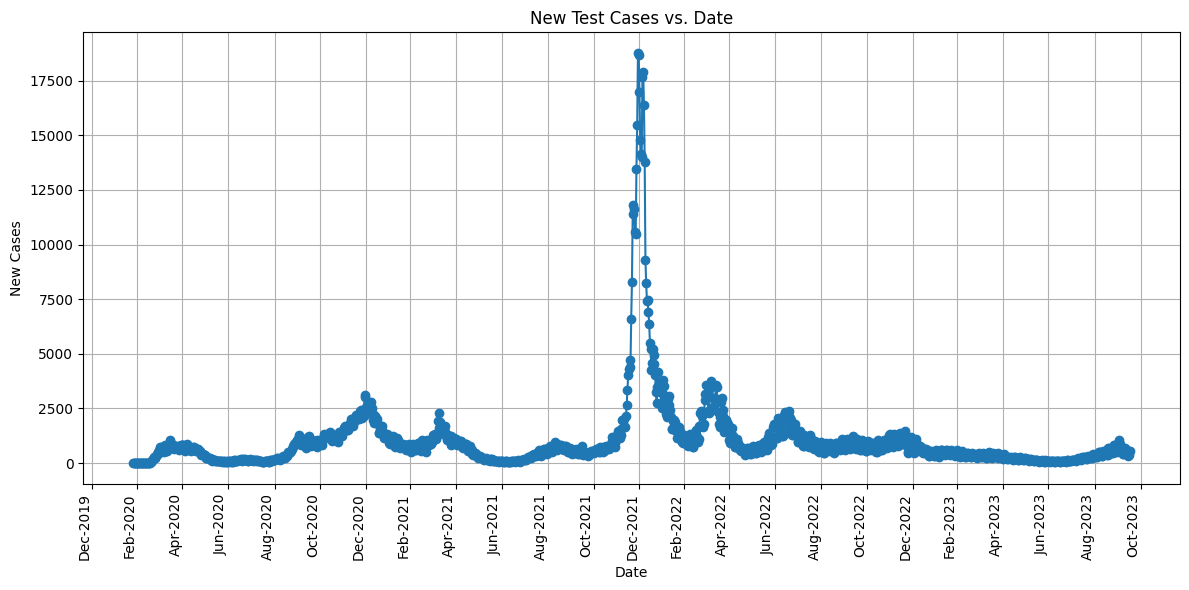

In [5]:
# Plotting Full Date Range
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(cases['Test Date'], cases['New Cases'], marker='o')
ax.set_title('New Test Cases vs. Date')
ax.grid(True)

# Setting x-ticks to only months and formatting them
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=-1, interval = 2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

# Rotating and aligning the tick labels for better display
fig.autofmt_xdate()
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.tight_layout()
plt.show()


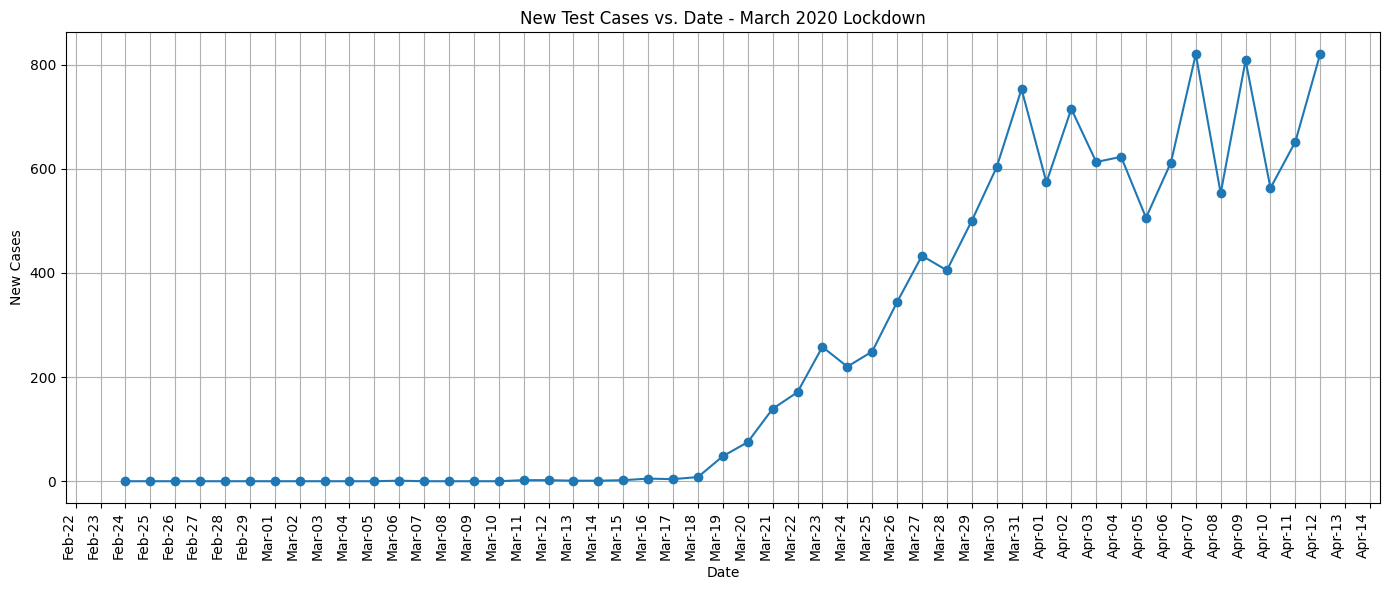

In [6]:
# Plotting 20/3/2020 lockdown
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(cases['Test Date'][:49], cases['New Cases'][:49], marker='o')
ax.set_title('New Test Cases vs. Date - March 2020 Lockdown')
ax.grid(True)

# Setting x-ticks to only months and formatting them
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

# Rotating and aligning the tick labels for better display
fig.autofmt_xdate()
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.tight_layout()
plt.show()

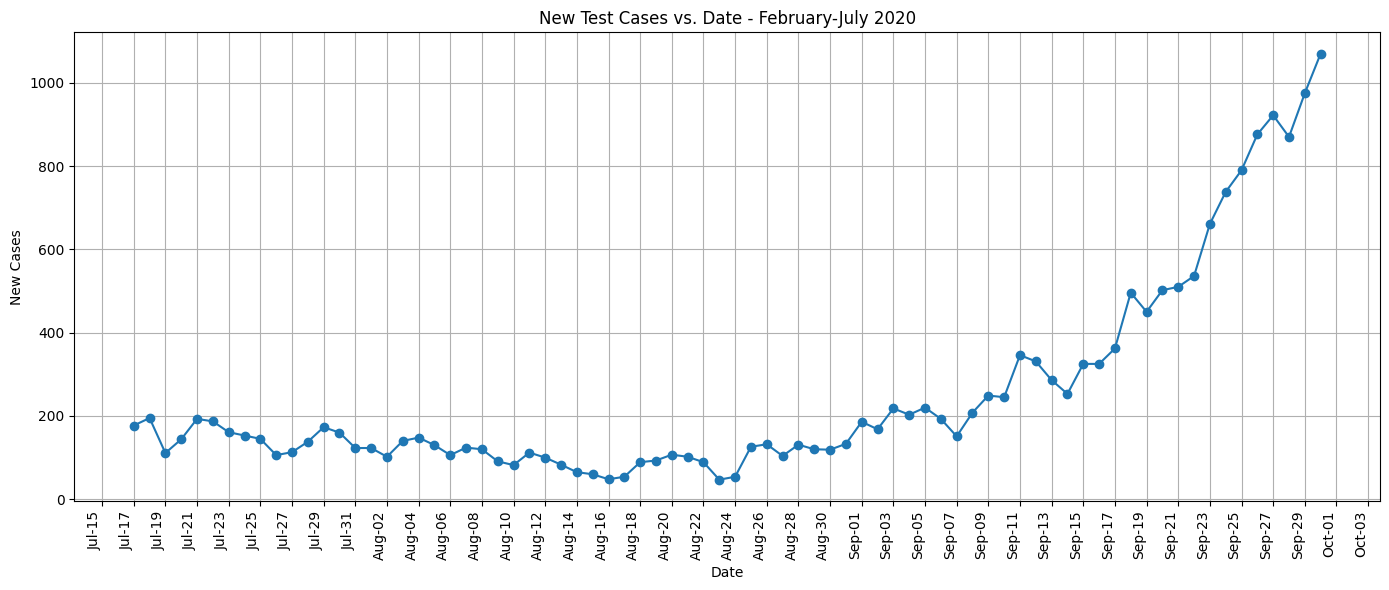

In [7]:
# Plotting 31/8/2020 School reopening
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(cases['Test Date'][144:220], cases['New Cases'][144:220], marker='o')
ax.set_title('New Test Cases vs. Date - February-July 2020')
ax.grid(True)

# Setting x-ticks to only months and formatting them
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

# Rotating and aligning the tick labels for better display
fig.autofmt_xdate()
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.tight_layout()
plt.show()

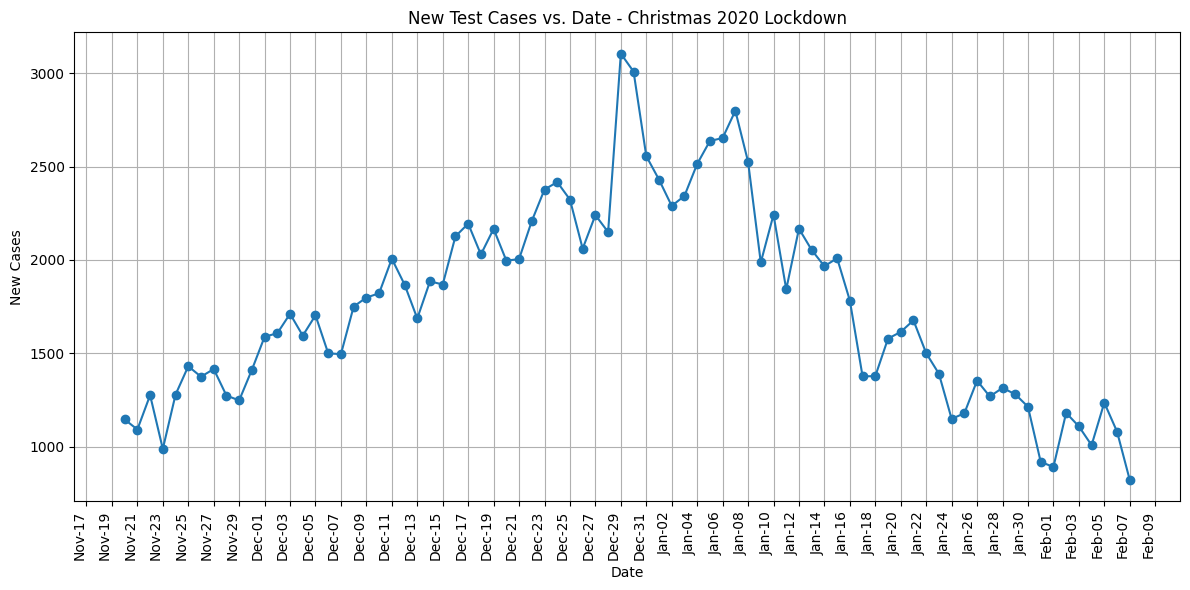

In [50]:
# Plotting Christmas 2020 Lockdown
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(cases['Test Date'][270:350], cases['New Cases'][270:350], marker='o')
ax.set_title('New Test Cases vs. Date - Christmas 2020 Lockdown')
ax.grid(True)

# Setting x-ticks to only months and formatting them
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

# Rotating and aligning the tick labels for better display
fig.autofmt_xdate()
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.tight_layout()
plt.show() 

# RDD Graph:
## Linearly fitted model

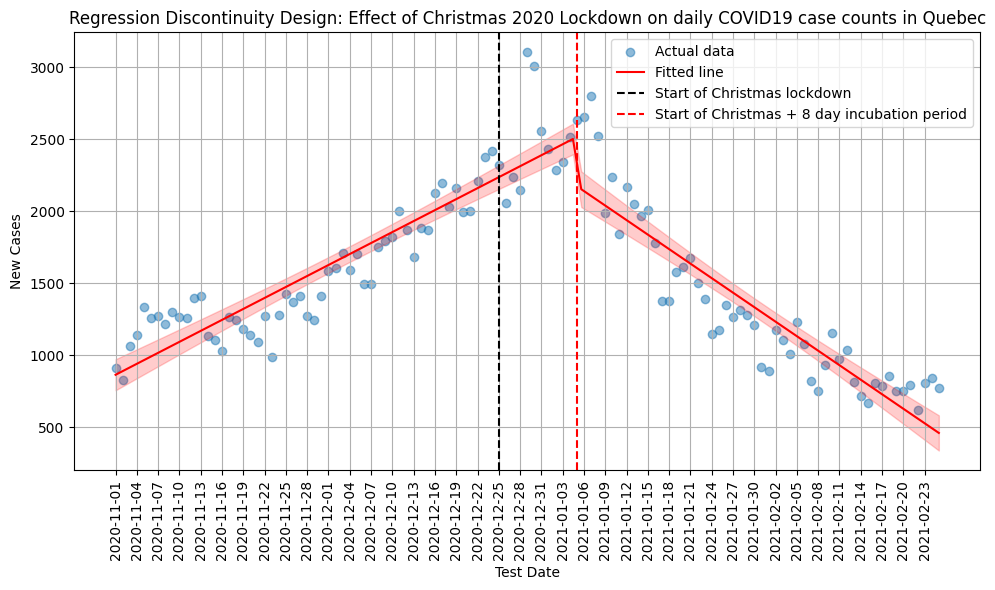

                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   2517.0371     54.448     46.228      0.000    2409.165    2624.909
threshold                   -342.3438     83.707     -4.090      0.000    -508.181    -176.506
days_since_event              25.4030      1.445     17.576      0.000      22.540      28.266
threshold:days_since_event   -58.9847      2.572    -22.930      0.000     -64.081     -53.888


In [55]:
#RDD linear regression graph:

# Set date limitations
event_date = '2021-01-05'
end_date = '2021-02-25'
start_date = '2020-11-01'

# Convert Test Date to datetime if not already
cases['Test Date'] = pd.to_datetime(cases['Test Date'])

# Define numerical x values as days since the start date
cases['days_since_event'] = (cases['Test Date'] -
                             pd.to_datetime(event_date)).dt.days
#Make a new dataframe to model using statsmodels.wls:
rdd_cases = cases.assign(threshold=(cases['days_since_event']>0).astype(int))

# Filter rdd_cases for dates between start_date and end_date
mask = (cases['Test Date'] >= start_date) & (cases['Test Date'] <= end_date)
rdd_cases = rdd_cases[mask]
model = smf.ols("Q('New Cases') ~ threshold + days_since_event + threshold:days_since_event", rdd_cases).fit()

# Define a range for "days_since_event"
x_range = np.linspace(rdd_cases['days_since_event'].min(), rdd_cases['days_since_event'].max(), 100)

# Create a DataFrame with this range and predict values using the model
df_plot = pd.DataFrame({'days_since_event': x_range})
df_plot['threshold'] = (df_plot['days_since_event'] > 0).astype(int)
df_plot['predicted'] = model.predict(df_plot)

# Compute the Confidence Intervals for Predictions
predictions = model.get_prediction(df_plot)
conf_int = predictions.conf_int(alpha=0.05)  # 95% CI by default
df_plot['lower'] = conf_int[:, 0]
df_plot['upper'] = conf_int[:, 1]

#Function to convert days_since_event back to Test Date:
def convert_to_date(days_since, base_date=pd.to_datetime(event_date)):
    return base_date + pd.Timedelta(days=days_since)
#Add a column Test Date to the df_plot: 
df_plot['Test Date'] = df_plot['days_since_event'].apply(convert_to_date)

#Plotting
plt.figure(figsize=(10, 6))
plt.scatter(rdd_cases['Test Date'], rdd_cases['New Cases'], alpha=0.5, label='Actual data')
plt.plot(df_plot['Test Date'], df_plot['predicted'], color='red', label='Fitted line')

# Adding confidence intervals
plt.fill_between(df_plot['Test Date'], df_plot['lower'], df_plot['upper'], color='red', alpha=0.2)
#Adding vertical event line: 
plt.axvline(x=pd.to_datetime('2020-12-25'), color='black', linestyle='--', label='Start of Christmas lockdown')  # event date line
plt.axvline(x=pd.to_datetime(event_date),color = 'red', linestyle = '--', label = f'Start of Christmas + 8 day incubation period')
#Setting up Xticks: 
xtick_locations = pd.date_range(start=start_date, end=end_date, freq='3D')
plt.xticks(xtick_locations, rotation=90)

#Formatting:
plt.xlabel('Test Date')
plt.ylabel('New Cases')
plt.title('Regression Discontinuity Design: Effect of Christmas 2020 Lockdown on daily COVID19 case counts in Quebec')
plt.grid(visible =True)
plt.legend()
plt.tight_layout()
plt.show()

print(model.summary().tables[1])



# RDD Graph: 
## Polynomial Fitted Model

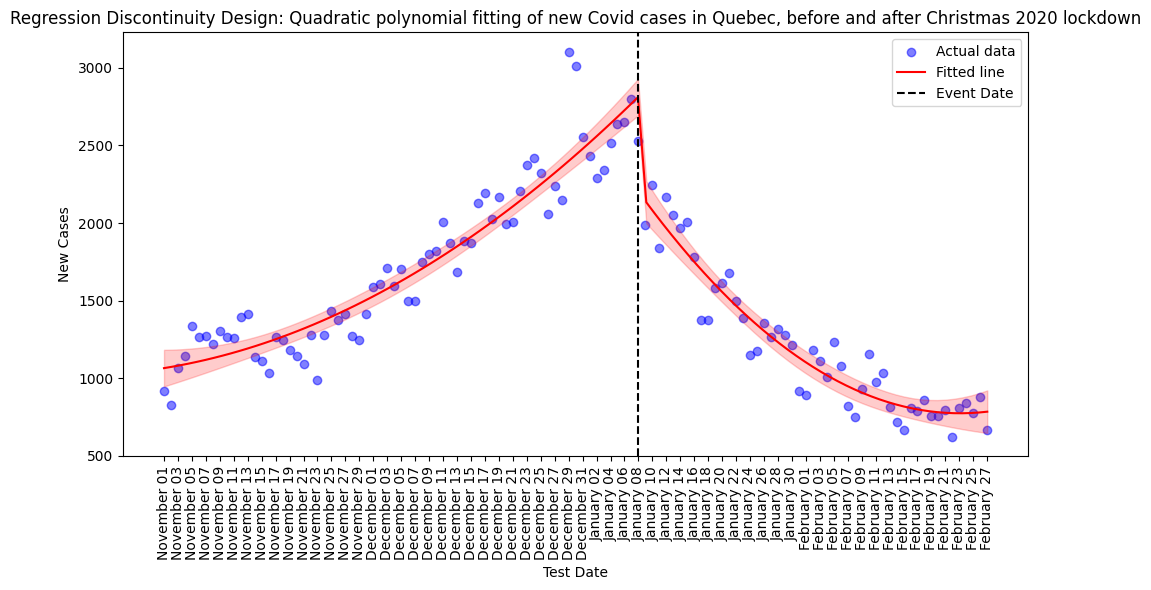

                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                           2813.9322     59.556     47.249      0.000    2695.942    2931.923
threshold                           -611.1157     95.753     -6.382      0.000    -800.820    -421.411
days_since_event                      44.1463      4.049     10.903      0.000      36.124      52.168
squared_days_since_event               0.2709      0.058      4.702      0.000       0.157       0.385
threshold:days_since_event          -106.1585      7.899    -13.440      0.000    -121.808     -90.509
threshold:squared_days_since_event     0.4017      0.141      2.845      0.005       0.122       0.681


In [48]:
#RDD Polynomial fitted model
# Set date limitations
event_date = '2021-01-08'
end_date = '2021-02-27'
start_date = '2020-11-01'

# Convert Test Date to datetime if not already
cases['Test Date'] = pd.to_datetime(cases['Test Date'])

# Define numerical x and x^2 values as days since the start date:
cases['days_since_event'] = (cases['Test Date'] -
                             pd.to_datetime(event_date)).dt.days
cases['squared_days_since_event'] = cases['days_since_event']**2

#Add dummy binary column 'threshold' to describe if Test Date came before or after the event:
rdd_cases = cases.assign(threshold=(cases['days_since_event']>0).astype(int))

# Filter rdd_cases for dates between start_date and end_date
mask = (cases['Test Date'] >= start_date) & (cases['Test Date'] <= end_date)
rdd_cases = rdd_cases[mask]
model = smf.ols("Q('New Cases') ~ threshold + days_since_event + squared_days_since_event + threshold:days_since_event + threshold:squared_days_since_event", rdd_cases).fit()

# Plot
# Define a range for "days_since_event"
x_range = np.linspace(rdd_cases['days_since_event'].min(), rdd_cases['days_since_event'].max(), 100)

# Create a DataFrame with this range and predict values using the model
df_plot = pd.DataFrame({'days_since_event': x_range})
df_plot['squared_days_since_event'] = df_plot['days_since_event']**2
df_plot['threshold'] = (df_plot['days_since_event'] > 0).astype(int)
df_plot['predicted'] = model.predict(df_plot)

# Compute the Confidence Intervals for Predictions
predictions = model.get_prediction(df_plot)
conf_int = predictions.conf_int(alpha=0.05)  # 95% CI by default
df_plot['lower'] = conf_int[:, 0]
df_plot['upper'] = conf_int[:, 1]

# Convert the days_since_event back to a datetime format for x-axis
df_plot['Test Date'] = pd.to_datetime(event_date) + pd.to_timedelta(df_plot['days_since_event'], unit='D')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(rdd_cases['Test Date'], rdd_cases['New Cases'], alpha=0.5, label='Actual data', color='blue')
plt.plot(df_plot['Test Date'], df_plot['predicted'], color='red', label='Fitted line')

# Adding confidence intervals
plt.fill_between(df_plot['Test Date'], df_plot['lower'], df_plot['upper'], color='red', alpha=0.2)

# Draw event date line
plt.axvline(x=pd.to_datetime(event_date), color='black', linestyle='--', label='Event Date') 

# Generate xtick locations every 5 days
xtick_locations = pd.date_range(start=start_date, end=end_date, freq='2D')

#Labels
plt.xlabel('Test Date')
plt.ylabel('New Cases')
plt.title('Regression Discontinuity Design: Quadratic polynomial fitting of new Covid cases in Quebec, before and after Christmas 2020 lockdown')
plt.legend()

# Format the x-axis to display month name and day only
date_format = mdates.DateFormatter('%B %d')
plt.gca().xaxis.set_major_formatter(date_format)

# Rotate xticks for better visibility
plt.xticks(xtick_locations, rotation=90) 

plt.tight_layout()
plt.show()

# Print the regression summary
print(model.summary().tables[1])
